# NYC's AirBnb

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Load and Clean AriBnb Data

In [117]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from geopandas import GeoDataFrame
import seaborn as sns
import requests
import json

In [116]:
listing_data = "Data/Detailed/listings.csv"
listings_df = pd.read_csv(listing_data)

listings_df.rename(columns = {'neighbourhood_group_cleansed': 'borough'}, inplace = True)
listings_df['price'] = listings_df['price'].str.replace('$', '').str.replace(',', '').astype(float)

organized_df = listings_df[["id", "host_response_time", "host_is_superhost", "borough", "zipcode", \
                            "latitude", "longitude", "is_location_exact", "room_type", "accommodates", \
                            "bathrooms", "bedrooms", "beds", "bed_type", "price","number_of_reviews", \
                            "review_scores_rating", "review_scores_cleanliness", "review_scores_checkin", \
                            "review_scores_communication", "review_scores_location", "review_scores_value", \
                            "cancellation_policy"]]
#organized_df = organized_df.dropna()
#organized_df.head()

## I. Geolocation of AriBnb

In [3]:
geo = organized_df.loc[organized_df["is_location_exact"]=="t", ["borough", "zipcode", "latitude", "longitude", "room_type", "price"]]

### geolocation of listings in NYC

In [4]:
mapbox_access_token = 'pk.eyJ1IjoiZ2oyMjk3IiwiYSI6ImNqd2xtaGdoZjA5bTEzeW56ZmM1aDVkaWEifQ.OQ8oKbUco3xfLHxipz0fJA'

data1 = [
    go.Scattermapbox(
        lat=geo["latitude"],
        lon=geo["longitude"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=1.3
        ),
    )
]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=40.7128,
            lon=-74.0060
        ),
        pitch=0,
        zoom=10
    ),
    width=750, 
    height=750
)

fig = go.Figure(data=data1, layout=layout)
py.iplot(fig, filename='AirBnb in NYC')

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## II. Number of AirBnb in NYC and each Borough

### Total Number of AirBnb in NYC

In [5]:
total_AirBnb = len(organized_df)
print(f"The total listings in NYC is {total_AirBnb}.")

The total listings in NYC is 48233.


### Number of AirBnb in each Borough

In [6]:
num_by_borough = pd.DataFrame(organized_df["borough"].value_counts())
num_by_borough.rename(columns={"borough": "Number of Listings"})

,Number of Listings
Manhattan,21513
Brooklyn,19809
Queens,5521
Bronx,1038
Staten Island,352


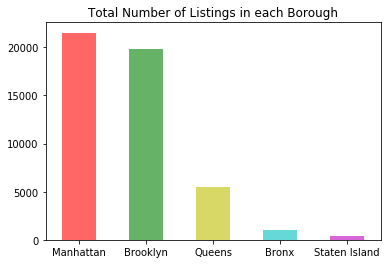

In [53]:
# bar chart: total number of AirBnb in each borough
num_by_borough.plot.bar(color = "rgycm", alpha = 0.6)
plt.xticks(rotation = 0)
plt.legend().remove()
plt.title("Total Number of Listings in each Borough")
plt.show()

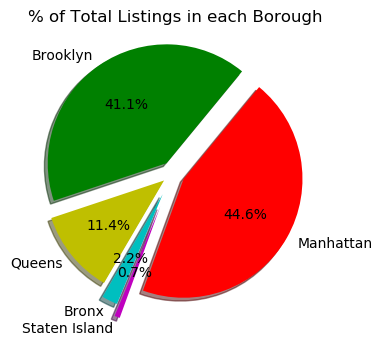

In [8]:
# pie chart: % of total AirBnb in each borough
labels = num_by_borough.index
sizes = num_by_borough["borough"]
explode = (0.1, 0.1, 0.1, 0.2, 0.3)
figure(num=None, figsize=(4, 4), dpi=100, facecolor='w', edgecolor='k')
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=250, colors="rgycm")
plt.axis('equal') 
plt.title("% of Total Listings in each Borough")
plt.show()

### Number of Listings by Zipcode

In [9]:
#read in shape file
zip_codes = GeoDataFrame.from_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')
zip_codes = zip_codes.rename(columns={"ZIPCODE": "zipcode"})
#zip_codes.head()

In [10]:
#converting zipcode column to string data type
organized_df['zipcode'] = organized_df['zipcode'].astype(int)
#returns only zip codes that are > or = to 10000
organized_df = organized_df[organized_df["zipcode"]>=10000]
organized_df['zipcode'] = organized_df['zipcode'].astype(str)
num_by_zipcode = organized_df["zipcode"].value_counts()
num_by_zipcode = pd.DataFrame({"zipcode": num_by_zipcode.index, "count": num_by_zipcode.values})
#num_by_zipcode.head()

In [11]:
zip_count = GeoDataFrame(pd.merge(num_by_zipcode, zip_codes, how='left', on='zipcode'))
zip_count = zip_count.dropna()
#zip_count.head()

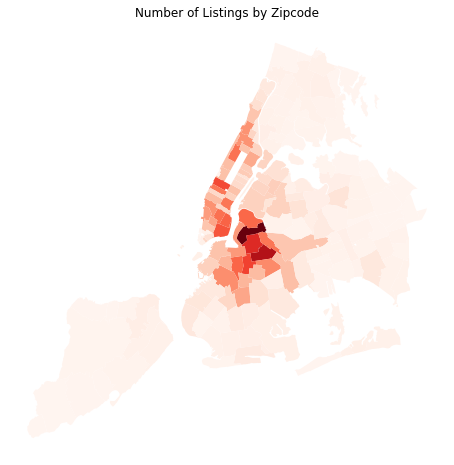

In [12]:
#Plotting the data
fig, ax = plt.subplots(figsize = (8,8))
zip_count.plot(column='count', cmap='Reds', alpha=1, ax=ax)
plt.title('Number of Listings by Zipcode')
plt.axis('off')
plt.show()

## III. Avg Price in NYC and each Borough

### Avg Price in NYC

In [13]:
#Average Price NYC
avg_price = round(organized_df["price"].mean(), 2)
print(f"The average AirBnb price in NYC is: ${avg_price}.")

The average AirBnb price in NYC is: $152.87.


### Avg Price in each Borough

In [64]:
# Average Price in each borough
average_price = round(organized_df.groupby("borough")["price"].mean(), 2)
average_price = pd.DataFrame(average_price)
average_price = average_price.reindex(["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island"])

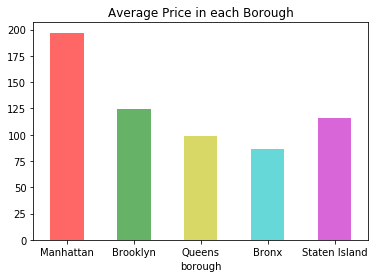

In [65]:
average_price.plot.bar(color = "rgycm", alpha = 0.6)
plt.xticks(rotation = 0)
plt.legend().remove()
plt.title("Average Price in each Borough")
plt.show()

### Avg Price by Zipcode

In [15]:
avg_price_zipcode = round(organized_df.groupby("zipcode")["price"].mean(), 2)
avg_price_zipcode = pd.DataFrame({"zipcode": avg_price_zipcode.index, "avg price": avg_price_zipcode.values})
zip_price = GeoDataFrame(pd.merge(avg_price_zipcode, zip_codes, how='left', on='zipcode'))
zip_price = zip_price.dropna()

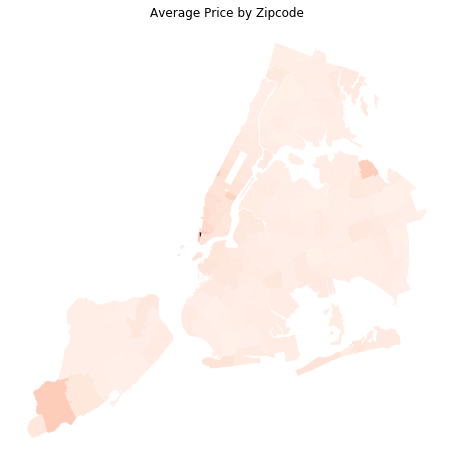

In [28]:
fig, ax = plt.subplots(figsize = (8,8))
zip_price.plot(column='avg price', cmap='Reds', alpha=1, ax=ax)
plt.title('Average Price by Zipcode')
plt.axis('off')
plt.show()

### Price of each Listings

In [50]:
size = geo["price"].values

data3 = [
    go.Scattermapbox(
        lat=geo["latitude"],
        lon=geo["longitude"],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=size*0.003
        ),
    )
]
fig = go.Figure(data=data3, layout=layout)
py.iplot(fig, filename='Price of AirBnb in NYC')

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### Price Range 

#### Price Range in NYC

In [17]:
bins = list(range(0, 1050, 50))
bins.append(10000)

group_names = [f"{i}-{i+50}" for i in bins]
del group_names[-1]
del group_names[-1]
group_names.append('1000-10000')

organized_df["Price Range ($)"] = pd.cut(organized_df["price"], bins, labels=group_names)

total_airbnb = len(organized_df)
price_sum = organized_df.groupby("Price Range ($)")["id"].count()
percent = round(price_sum / total_airbnb*100, 2)
price_summary = pd.DataFrame({"Number": price_sum, "Percent(%)": percent})
price_summary = price_summary.reset_index()

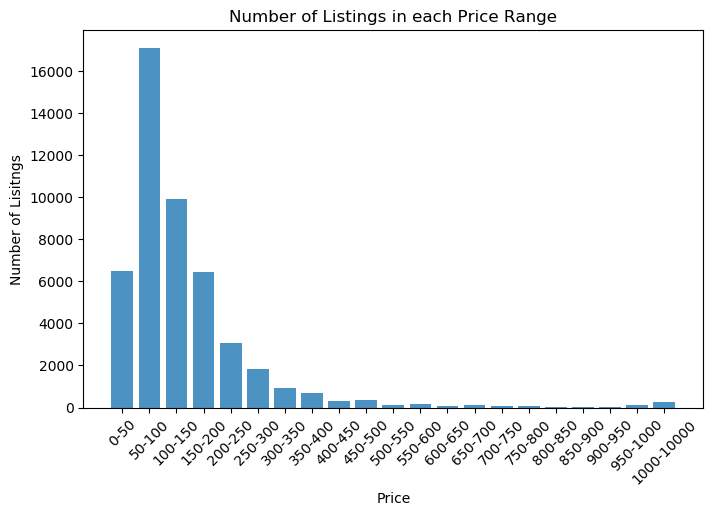

In [18]:
# bar chart: total number of airbnb in each price range
figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')
plt.bar(group_names, price_summary["Number"], alpha = 0.8)
plt.xticks(rotation = 45)
plt.xlabel("Price")
plt.ylabel("Number of Lisitngs")
plt.title("Number of Listings in each Price Range")
plt.show()

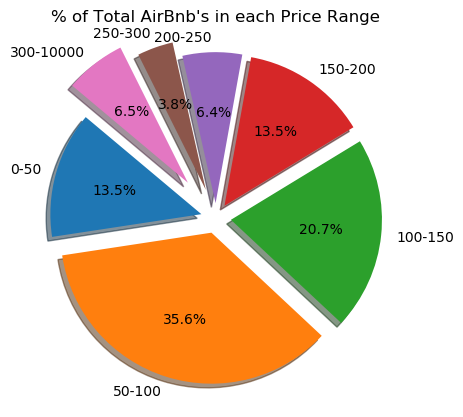

In [19]:
# pie chart: % of total  airbnb in each price range
sizes = price_summary["Number"].tolist()[0:6]
sizes.append(sum(price_summary["Number"][6:-1]))

labels = group_names[0:6]
labels.append("300-10000")
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.3)
#colors = ["red", "orange", "lightcoral", "lightskyblue", "green", "black", "yellow"]
figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')
plt.pie(sizes, labels=labels, explode=explode, autopct="%1.1f%%", shadow=True, startangle=140)
plt.title("% of Total AirBnb's in each Price Range")
plt.show()

#### Price Range in each Borough

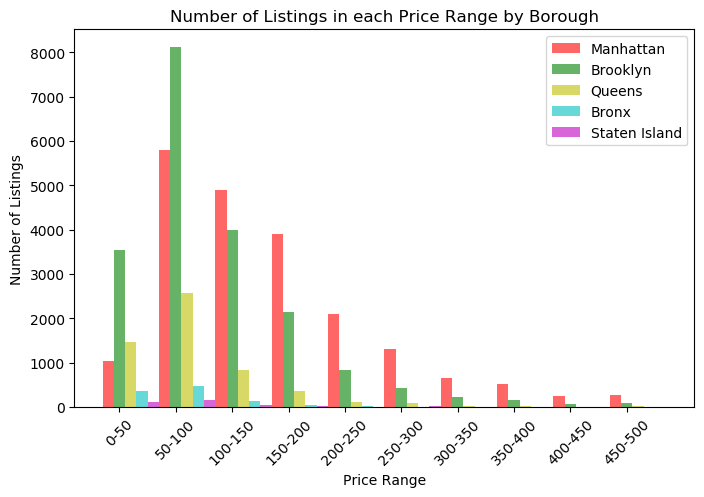

In [20]:
manhattan = organized_df.loc[organized_df["borough"]=="Manhattan"].groupby("Price Range ($)")["id"].count()[0:10]
brooklyn = organized_df.loc[organized_df["borough"]=="Brooklyn"].groupby("Price Range ($)")["id"].count()[0:10]
queens =  organized_df.loc[organized_df["borough"]=="Queens"].groupby("Price Range ($)")["id"].count()[0:10]
bronx = organized_df.loc[organized_df["borough"]=="Bronx"].groupby("Price Range ($)")["id"].count()[0:10]
staten_island = organized_df.loc[organized_df["borough"]=="Staten Island"].groupby("Price Range ($)")["id"].count()[0:10]

figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')

barWidth = 0.2

r1 = np.arange(len(manhattan))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

plt.bar(r1, manhattan, width=barWidth, color="r", alpha = 0.6, label =  "Manhattan")
plt.bar(r2, brooklyn, width=barWidth, color="g", alpha = 0.6, label =  "Brooklyn")
plt.bar(r3, queens, width=barWidth, color="y", alpha = 0.6, label =  "Queens")
plt.bar(r4, bronx, width=barWidth, color="c", alpha = 0.6, label =  "Bronx")
plt.bar(r5, staten_island, width=barWidth, color="m", alpha = 0.6, label =  "Staten Island")
plt.xticks([r + barWidth for r in range(len(manhattan))], group_names[0:10])
plt.xticks(rotation = 45)
plt.xlabel("Price Range")
plt.ylabel("Number of Listings")
plt.title("Number of Listings in each Price Range by Borough")
plt.legend()
plt.show()

## IV. Room Type

### geolocation by room type

In [21]:
entire_room = go.Scattermapbox(
    lat=geo.loc[geo["room_type"]=="Entire home/apt"]["latitude"].values,
    lon=geo.loc[geo["room_type"]=="Entire home/apt"]["longitude"].values,
    mode='markers',
    name="Entrie home/apt",
    marker=go.scattermapbox.Marker(
        size=1.5,
        color = "orangered"
    ),
)

private_room = go.Scattermapbox(
    lat=geo.loc[geo["room_type"]=="Private room"]["latitude"].values,
    lon=geo.loc[geo["room_type"]=="Private room"]["longitude"].values,
    mode='markers',
    name="Private room",
    marker=go.scattermapbox.Marker(
        size=1.5,
        color = "limegreen"            
    ),
)

shared_room = go.Scattermapbox(
    lat=geo.loc[geo["room_type"]=="Shared room"]["latitude"].values,
    lon=geo.loc[geo["room_type"]=="Shared room"]["longitude"].values,
    mode='markers',
    name="Shared room",
    marker=go.scattermapbox.Marker(
        size=1.5,
        color = "blue"           
    ),
)

data2 = [entire_room, private_room, shared_room]
fig = go.Figure(data=data2, layout=layout)
py.iplot(fig, filename='AirBnb in NYC by room type')

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



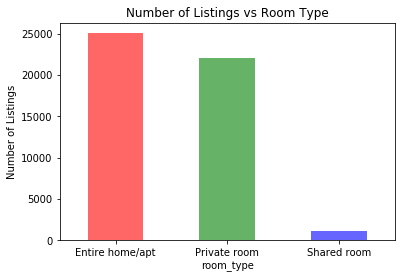

In [22]:
room_type_num = pd.DataFrame(organized_df.groupby("room_type")["id"].count())
room_type_num.plot.bar(color="rgb", alpha = 0.6)
plt.xticks(rotation = "0")
plt.ylabel("Number of Listings")
plt.title("Number of Listings vs Room Type")
plt.legend().remove()
plt.show()

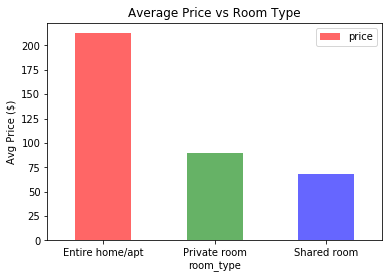

In [23]:
room_type_price = pd.DataFrame(organized_df.groupby("room_type")["price"].mean())

room_type_price.plot.bar(color = "rgb", alpha = 0.6)
plt.xticks(rotation = "0")
plt.ylabel("Avg Price ($)")
plt.title("Average Price vs Room Type")
plt.show()

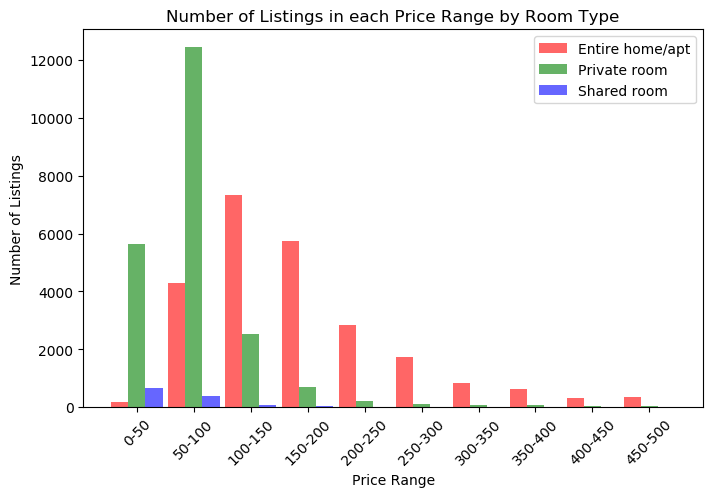

In [24]:
entire_home = organized_df.loc[organized_df["room_type"]=="Entire home/apt"].groupby("Price Range ($)")["id"].count()[0:10]
private_room = organized_df.loc[organized_df["room_type"]=="Private room"].groupby("Price Range ($)")["id"].count()[0:10]
shared_room = organized_df.loc[organized_df["room_type"]=="Shared room"].groupby("Price Range ($)")["id"].count()[0:10]
figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')
barWidth = 0.3

r1 = np.arange(len(entire_home))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, entire_home, color="r", width=barWidth, alpha = 0.6, label =  "Entire home/apt")
plt.bar(r2, private_room, color="g", width=barWidth, alpha = 0.6, label =  "Private room")
plt.bar(r3, shared_room, color="b", width=barWidth, alpha = 0.6, label =  "Shared room")
plt.xticks([r + barWidth for r in range(len(entire_home))], group_names[0:10])
plt.xticks(rotation = 45)
plt.xlabel("Price Range")
plt.ylabel("Number of Listings")
plt.title("Number of Listings in each Price Range by Room Type")
plt.legend()
plt.show()

## Price vs Population

In [123]:
url = "https://data.cityofnewyork.us/resource/xywu-7bv9.json"
response = requests.get(url)
response_json = response.json()
#print(json.dumps(response_json, indent=4, sort_keys=True))

population=[]
borough=[]
percent = []
for i in range(len(response_json)):
    p = response_json[i]["_2020"]
    b = response_json[i]["borough"]
    per = response_json[i]["_2020_boro_share_of_nyc_total"]
    population.append(p)
    borough.append(b)
    percent.append(per)


population_2020 = pd.DataFrame({"population": population, "borough": borough, "percent": percent})
population_2020

,population,borough,percent
0,8550971,NYC Total,100.00
1,1446788,Bronx,16.92
2,2648452,Brooklyn,30.97
3,1638281,Manhattan,19.16
4,2330295,Queens,27.25
5,487155,Staten Island,5.70


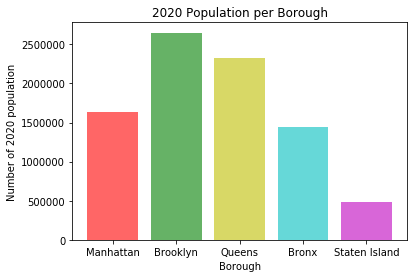

In [124]:
population_2020.iloc[1:6, 0]

Boroughs = ["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island"]
population_2020 = [1638281, 2648452, 2330295, 1446788, 487155]
plt.bar(Boroughs, population_2020, color="rgycm", align="center", alpha = 0.6)
plt.title("2020 Population per Borough")
plt.xlabel("Borough")
plt.ylabel("Number of 2020 population")
plt.show()

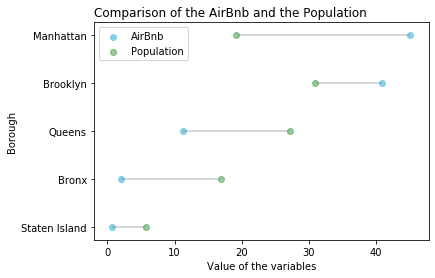

In [126]:
# percent of each borough
AirBnb = [45.1, 40.8, 11.2, 2.1, 0.7]
Population =[19.16, 30.97, 27.25, 16.92, 5.70]
df = pd.DataFrame({'group':["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island"], 'AirBnb':AirBnb , 'Population':Population })

ordered_df = df.sort_values(by='AirBnb')
my_range=range(1,len(df.index)+1)

plt.hlines(y=my_range, xmin=ordered_df['AirBnb'], xmax=ordered_df['Population'], color='grey', alpha=0.4)
plt.scatter(ordered_df['AirBnb'], my_range, color='skyblue', alpha=1, label='AirBnb')
plt.scatter(ordered_df['Population'], my_range, color='green', alpha=0.4 , label='Population')
plt.legend()

plt.yticks(my_range, ordered_df['group'])
plt.title('Comparison of the AirBnb and the Population', loc='left')
plt.xlabel('Value of the variables')
plt.ylabel('Borough')
plt.show()

## What drives price?

In [107]:
data = organized_df[["price", "host_is_superhost", "latitude", "longitude", "room_type", \
                     "accommodates", "bathrooms", "bedrooms", "beds", "bed_type", "number_of_reviews", \
                     "review_scores_checkin", "review_scores_communication", \
                     "review_scores_location", "review_scores_value"]]
data = data.dropna()

superhost = pd.get_dummies(data["host_is_superhost"])
room_type = pd.get_dummies(data["room_type"])
bed_type = pd.get_dummies(data["bed_type"])
data = pd.concat([data, superhost, room_type, bed_type], axis=1, join_axes=[data.index])
data.drop(["host_is_superhost", "room_type", "bed_type", "f"], axis=1, inplace=True)
data = data.rename(columns={"t": "isSuperhost"})
data = data[data["price"]<=1000]
data.head()

,price,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_checkin,review_scores_communication,...,review_scores_value,isSuperhost,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,149.0,40.64749,-73.97237,2,1.0,1.0,1.0,9,10.0,10.0,...,10.0,0,0,1,0,0,0,0,0,1
1,225.0,40.75362,-73.98377,2,1.0,0.0,1.0,44,10.0,10.0,...,9.0,0,1,0,0,0,0,0,0,1
3,89.0,40.68514,-73.95976,3,1.0,1.0,4.0,258,10.0,10.0,...,9.0,0,1,0,0,0,0,0,0,1
4,105.0,40.76260,-73.99304,2,1.0,1.0,2.0,27,10.0,10.0,...,9.0,0,1,0,0,0,0,0,0,1
6,200.0,40.74767,-73.97500,2,1.0,1.0,1.0,71,10.0,10.0,...,9.0,0,1,0,0,0,0,0,0,1


In [108]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data)
data_norm = pd.DataFrame(np_scaled)
listNames = list(data.columns.values)
data_norm.columns = listNames
data_norm.head()

,price,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_checkin,review_scores_communication,...,review_scores_value,isSuperhost,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,0.149,0.342394,0.507696,0.066667,0.133333,0.090909,0.045455,0.014778,1.0,1.0,...,1.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.225,0.604178,0.486059,0.066667,0.133333,0.000000,0.045455,0.072250,1.0,1.0,...,0.875,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.089,0.435263,0.531630,0.133333,0.133333,0.090909,0.181818,0.423645,1.0,1.0,...,0.875,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.105,0.626329,0.468465,0.066667,0.133333,0.090909,0.090909,0.044335,1.0,1.0,...,0.875,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.200,0.589502,0.502705,0.066667,0.133333,0.090909,0.045455,0.116585,1.0,1.0,...,0.875,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


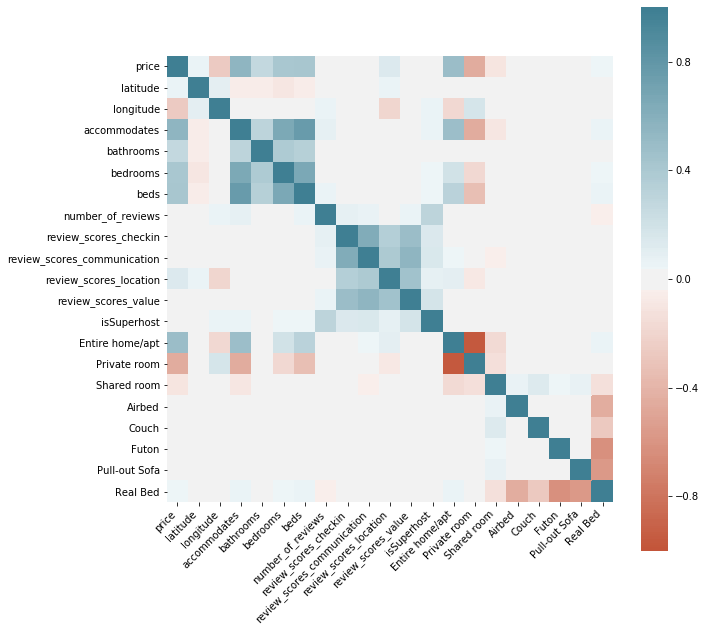

In [114]:
corr = data_norm.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');